# Predicting sunspots using LSTMs and CNNs

Sunspots are areas that appear dark on the surface of the Sun, the photosphere. It appears darker because it is cooler than the rest of the Sun's surface. However, sunspot temperatures are still very hot, around 6,500 degrees Fahrenheit. The photosphere is the visible surface of the Sun from which most of the sunlight that reaches Earth directly is emitted. It is relatively cold because it forms where the magnetic field is particularly strong. These magnetic fields are so strong that they prevent some of the heat in the sun from reaching the surface of the earth. The magnetic fields in such areas are about 2,500 times stronger than Earth's. They usually consist of a dark area called 'amber' surrounded by a lighter area called 'penumbra'. With each solar cycle, the number of sunspots increases or decreases. The current solar cycle, which began in 2008, is at a "solar minimum" when the number of sunspots and solar flares is routinely at low levels. 

![picture](https://drive.google.com/uc?id=1Ff3eJq1Gybf9AdxKtazDCo_gjJffzkrh)

[Sunspots: What are they, and why do they occur? | Space](https://www.space.com/sunspots-formation-discovery-observations)


[Sunspot - Assignment Point](https://assignmentpoint.com/sunspot/)


[A hyperactive sunspot just hurled a huge X-class solar flare into space - Bing video
](https://www.bing.com/videos/search?q=NASA+Sunspots&&view=detail&mid=0ACC4E46B052BEF0ABD00ACC4E46B052BEF0ABD0&&FORM=VRDGAR&ru=%2Fvideos%2Fsearch%3Fq%3DNASA%2BSunspots%26FORM%3DRESTAB)

Note: Please upload the notebook on kaggle and use the following data set link to run the notebook: https://www.kaggle.com/datasets/robervalt/sunspots

# Initialising tensorflow envirvonment

In [39]:
import tensorflow as tf
tf.__version__

'2.6.2'

# Importing libraries and dataset

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore") 

In [41]:
data=pd.read_csv("../input/sunspots/Sunspots.csv")

In [42]:
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [43]:
data.shape

(3265, 3)

# Building the dataset and plotting time series graph of the sunspots

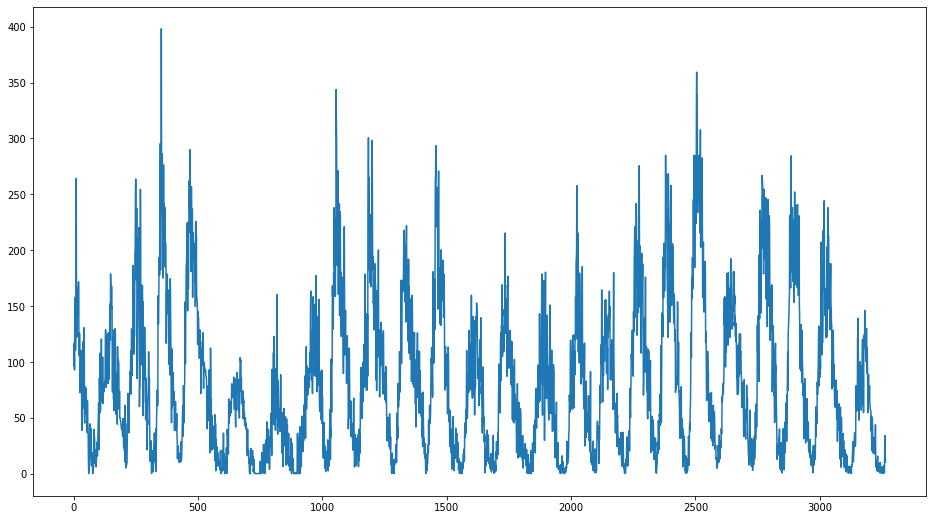

In [44]:
import csv
time_step = []
sunspots = []

with open('../input/sunspots/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(16, 9))
plt.plot(time, series)

In [45]:
series

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

In [46]:
np.array(data['Monthly Mean Total Sunspot Number'])

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

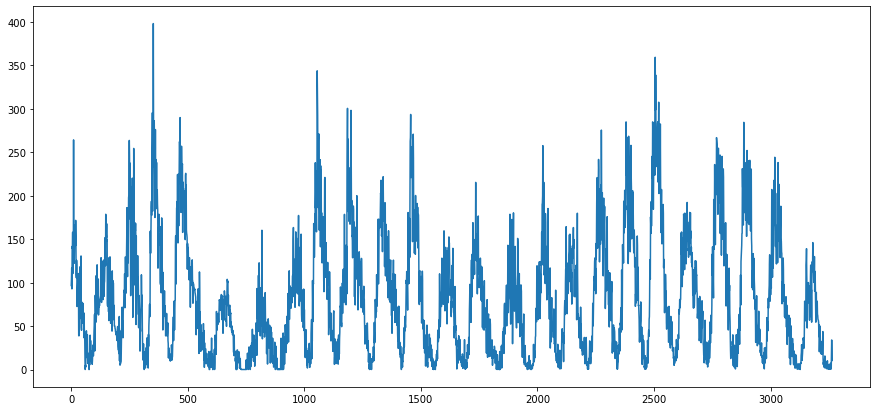

In [47]:
plt.figure(figsize=(15,7))
plt.plot(data['Monthly Mean Total Sunspot Number'])

# Building helper functions for pre processing and model training

In [48]:
#Helper function: Training data generation

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [49]:
#Defining model training preprocessing and parameters

def model_forecast(model, series, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [50]:
np.array(data['Unnamed: 0'])

array([   0,    1,    2, ..., 3262, 3263, 3264])

In [51]:
series = np.array(data['Monthly Mean Total Sunspot Number'])
time = np.array(data['Unnamed: 0'])

window_size=64
batch_size=256   #setting batch size as 2^8, 256
shuffle_buffer_size= 1000
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [52]:
dataset

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

# Finding best learning rate to optimise model training

In [62]:
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

window_size = 120
batch_size = 256
shuffle_buffer_size= 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(90, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(120, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(30, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [63]:
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
12/12 [==============================] - 4s 40ms/step - loss: 84.5789 - mae: 80.7108
Epoch 2/150
12/12 [==============================] - 1s 46ms/step - loss: 84.4887 - mae: 80.6313
Epoch 3/150
12/12 [==============================] - 1s 48ms/step - loss: 84.3740 - mae: 80.5320
Epoch 4/150
12/12 [==============================] - 1s 49ms/step - loss: 84.2424 - mae: 80.4205
Epoch 5/150
12/12 [==============================] - 1s 48ms/step - loss: 84.0900 - mae: 80.2955
Epoch 6/150
12/12 [==============================] - 1s 50ms/step - loss: 83.9095 - mae: 80.1559
Epoch 7/150
12/12 [==============================] - 1s 48ms/step - loss: 83.6888 - mae: 79.9999
Epoch 8/150
12/12 [==============================] - 1s 48ms/step - loss: 83.4335 - mae: 79.8300: 0s - loss: 78.3770 - mae: 74.
Epoch 9/150
12/12 [==============================] - 1s 51ms/step - loss: 83.1767 - mae: 79.6469
Epoch 10/150
12/12 [==============================] - 1s 49ms/step - loss: 82.9213 - mae: 79.442

# Since the learning rates increase exponentially, we use a semi log plot to accomodate all the datapoints in an optimally sized plot

(1e-08, 0.0001, 0.0, 40.0)

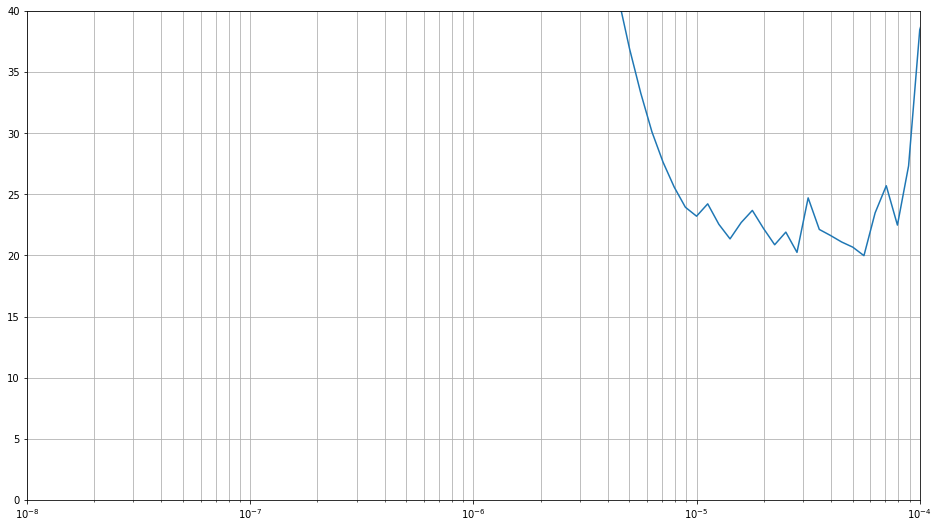

In [55]:
fig = plt.figure(figsize=(16, 9))

plt.semilogx(history.history["lr"], history.history["loss"])
plt.grid(True, which="both", ls="-")
plt.axis([1e-8, 1e-4, 0, 40])

# Using learning rate of 4.6e-5 and CNN, LSTM hybrid model

In [64]:
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(90, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(120, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(30, activation="relu", activity_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=4.6e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=750)

Epoch 1/750
12/12 [==============================] - 4s 75ms/step - loss: 63.2135 - mae: 60.6525
Epoch 2/750
12/12 [==============================] - 1s 48ms/step - loss: 54.0734 - mae: 53.6060
Epoch 3/750
12/12 [==============================] - 1s 46ms/step - loss: 35.3388 - mae: 34.3762
Epoch 4/750
12/12 [==============================] - 1s 47ms/step - loss: 31.9008 - mae: 30.6462
Epoch 5/750
12/12 [==============================] - 1s 49ms/step - loss: 32.8907 - mae: 32.4830
Epoch 6/750
12/12 [==============================] - 1s 46ms/step - loss: 28.0857 - mae: 27.7315
Epoch 7/750
12/12 [==============================] - 1s 51ms/step - loss: 24.8859 - mae: 24.6755
Epoch 8/750
12/12 [==============================] - 1s 49ms/step - loss: 22.2779 - mae: 22.0995
Epoch 9/750
12/12 [==============================] - 1s 48ms/step - loss: 20.7092 - mae: 20.5601
Epoch 10/750
12/12 [==============================] - 1s 50ms/step - loss: 19.9788 - mae: 19.8862
Epoch 11/750
12/12 [=========

# Plotting losses and results

Here we use the mean absolute error as the loss metric, whose mathematical representation is as follows

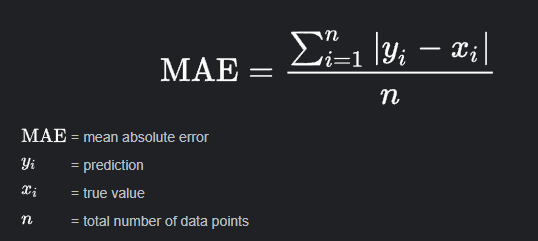

<Figure size 432x288 with 0 Axes>

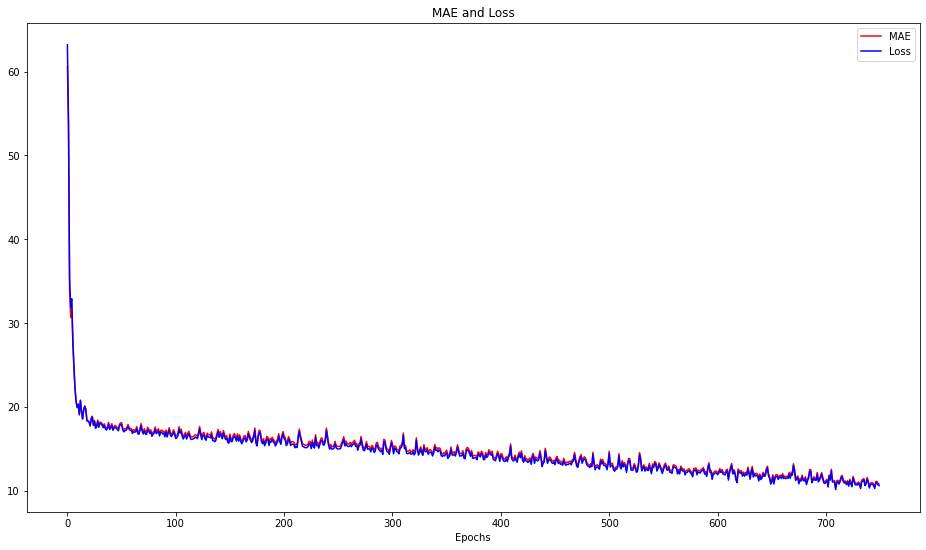

<Figure size 432x288 with 0 Axes>

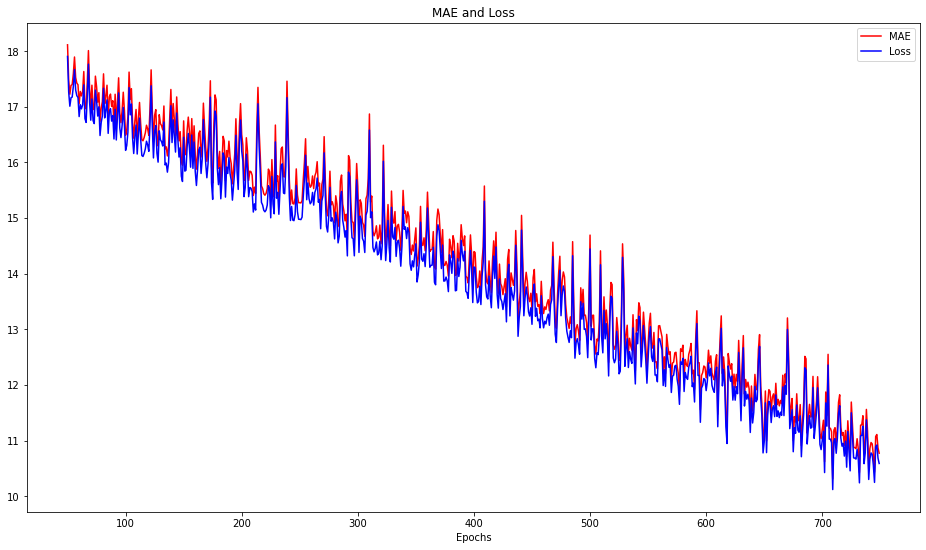

<Figure size 432x288 with 0 Axes>

In [65]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

fig = plt.figure(figsize=(16, 9))

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = mae[50:]
loss_zoom = loss[50:]

fig = plt.figure(figsize=(16, 9))

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.legend(["MAE", "Loss"])

plt.figure()

In [66]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

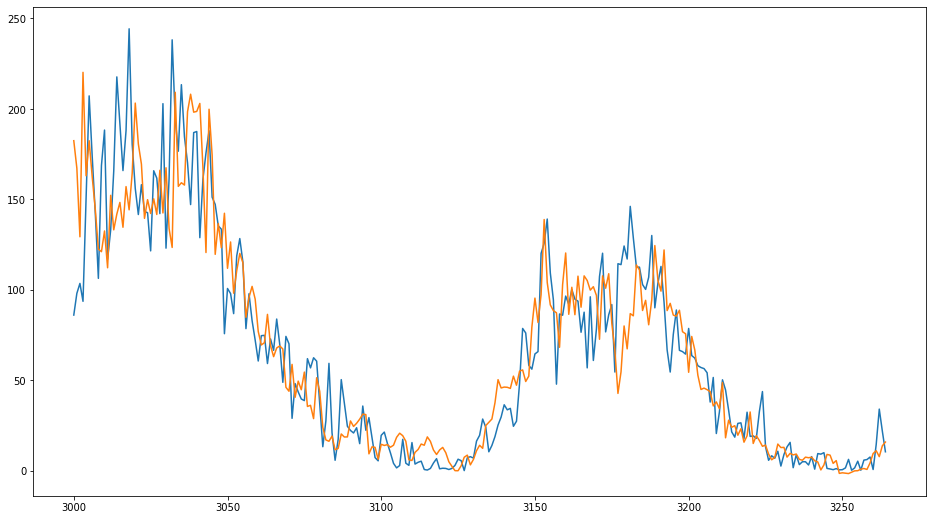

In [67]:
plt.figure(figsize=(16, 9))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)

In [68]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.018587